<a href="https://colab.research.google.com/github/fuyu-quant/quantum_algorithm/blob/main/TensorFlow%20Quantum/QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QNN(量子ニューラルネットワーク)
* [TensorFlow Quantum](https://www.tensorflow.org/quantum/tutorials/mnist)を参考にする.
* [Classification with Quantum Neural Networks on Near Term Processors](https://arxiv.org/pdf/1802.06002.pdf)で紹介されたQNNのアプローチを構築.


### 必要なものをインストール

In [ ]:
!pip install tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8 MB 3.8 kB/s 
     |████████████████████████████████| 448 kB 58.5 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.8 MB 41.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e715aa61c6e18d8f1ca4154a9e5eab5df3df02e2ae2f0e5100b6785255187638
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succe

In [ ]:
!pip install cirq==0.7.0 pathos==0.2.5 tensorflow-quantum==0.2.0

     |████████████████████████████████| 1.2 MB 4.2 MB/s 
     |████████████████████████████████| 162 kB 68.9 MB/s 
     |████████████████████████████████| 4.5 MB 42.3 MB/s 
     |████████████████████████████████| 1.2 MB 47.8 MB/s 
     |████████████████████████████████| 1.7 MB 51.2 MB/s 
     |████████████████████████████████| 5.3 MB 38.4 MB/s 
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 114 kB 71.9 MB/s 
     |████████████████████████████████| 114 kB 69.5 MB/s 
     |████████████████████████████████| 114 kB 76.6 MB/s 
     |████████████████████████████████| 114 kB 64.8 MB/s 
     |████████████████████████████████| 111 kB 70.7 MB/s 
     |████████████████████████████████| 111 kB 70.6 MB/s 
     |████████████████████████████████| 109 kB 70.7 MB/s 
     |████████████████████████████████| 109 kB 74.7 MB/s 
     |████████████████████████████████| 95 kB 4.8 MB/s 
     |████████████████████████████████| 95 kB 4.7 MB/s 
     |███████████████

## ライブラリのインポート

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import pandas as pd
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# データの用意
* mnistのデータを用意
* 量子デバイス(今回はシミュレーション)では大きいデータ量を扱えないので画像データをダウンスケールする
* 二値分類を行うためmnistのデータを「3」と「6」のデータに絞る

### データの用意とダウンスケール

In [ ]:
#kerasでmnistのデータをダウンロード
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 画像データを[0,255]から[0.0,1.0]にスケーリング
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [ ]:
#学習データを3と6に限定
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


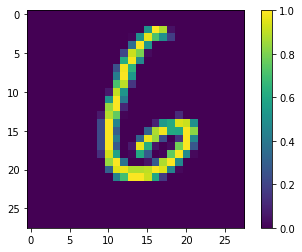

In [ ]:
plt.imshow(x_train[7, :, :, 0])
plt.colorbar()

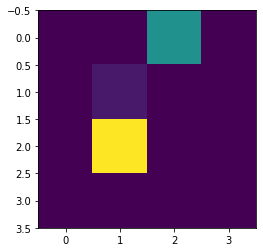

In [ ]:
#画像のデータをダウンスケールする
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

#ダウンスケール後の画像を表示
plt.imshow(x_train_small[7, :, :, 0])

### 両方のクラスに属する画像の削除

In [ ]:
# 両方のクラスに属する画像の削除
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 出力のラベルを0,1に変換

In [ ]:
# 出力ラベルがブール値になっているので[0,1]の値に変換
y_train_binary = 1.0*y_train_nocon
y_test_binary = 1.0*y_test

# 入力する量子状態の用意
* 入力する値は0か1の二値で用意する
* 0か1の状態で入力するため，入力が1となる量子ビットに対してはXゲートを作用させ反転させてから入力する



### 量子状態の入力のための変換
* 量子状態の入力には0か1の値を用いるため，閾値を決め0か1の値に変換する．

In [ ]:
#0.5を閾値として0か１のバイナリー変数に変換
threshold = 0.5

x_train_bin = np.array(x_train_nocon > threshold, dtype = np.float32)
x_test_bin = np.array(x_test_small > threshold, dtype = np.float32)

### 入力する量子状態を変換する関数の用意

In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

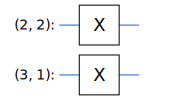

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
#画素値が閾値を超えたインデックスの表示
#閾値を超えているインデックスにXゲートがかかっているかを確認
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

### Cirq回路をtfqのためのテンソルに変換
* tfq.convert_to_tensorによってテンソル表現に変換する

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# QNNモデルの作成


* QNNモデルを作成するのに必要な量子回路の繰り返しを作るクラスの定義

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

* 量子回路の繰り返しを実際に出力してみる

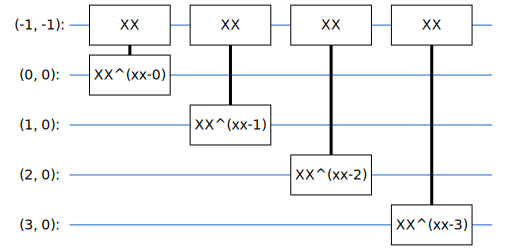

In [ ]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

* 実際に学習に使う量子回路の作成
* 入力はデータサイズの16量子ビット+出力を取り出すための1量子ビットの合計17量子ビット
* X軸回転とZ軸回転の両方を使い関数を表現するためXXゲートの操作のあと，ZZゲートの操作をする

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # XXゲート，ZZゲートの繰り返し
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # 最後に測定量子ビットにアダマールゲートをかける
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

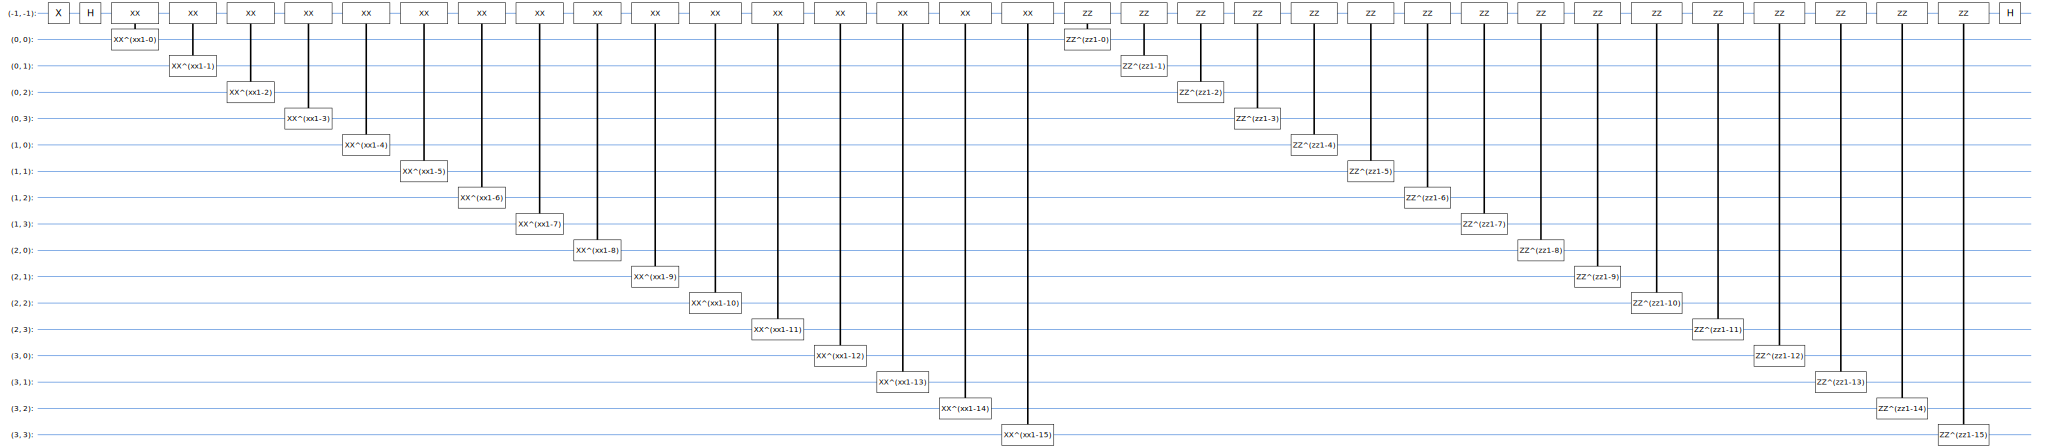

In [ ]:
#量子回路の作成
model_circuit, model_readout = create_quantum_model()

#量子回路の可視化
SVGCircuit(model_circuit)

* モデル全体の作成

In [ ]:
# 古典のTensorFlow同様にモデルを作成する
model = tf.keras.Sequential([
    # データを入力しtf.stringに変換するためのレイヤー
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # [-1,1]の間の値を出力する量子回路のレイヤー
    tfq.layers.PQC(model_circuit, model_readout),
])


# 損失関数，最適化関数，評価関数を指定してコンパイル
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'])

In [ ]:
# モデルのパラメータなどを確認
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


# QNNの学習
* 学習はTensorFlowでNNモデルを学習させる時とほとんど変わらない
* TensorFlow QuantumはGPUには載せられないため学習時間は結構かかる(2022/3/29時点)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

#NUM_EXAMPLES = len(x_train_tfcirc)
NUM_EXAMPLES = 1000

#学習に時間がかかるのでデータを減らす
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_binary_sub = y_train_binary[:NUM_EXAMPLES]

In [ ]:
# モデルの保存方法の指定
checkpoint_filepath = "weight.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,   # 保存path
    save_weights_only=True,      # 重みのみを保存
    monitor='val_acc',             # validataionのACCの値に基づいて重みを保存する
    mode='max',                  # validataionのACCが最大となった時重みを保存する
    save_best_only=True          # ACCが改善したときのみ保存する
)

# モデルの学習の開始
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_binary_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_binary),
      callbacks=[model_checkpoint_callback]
      )

Train on 1000 samples, validate on 1968 samples
Epoch 1/10
1000/1000 [==============================] - 163s 163ms/sample - loss: 1.5810 - accuracy: 0.5400 - val_loss: 1.2817 - val_accuracy: 0.6494
Epoch 2/10
1000/1000 [==============================] - 174s 174ms/sample - loss: 0.9697 - accuracy: 0.8030 - val_loss: 1.1291 - val_accuracy: 0.8415
Epoch 3/10
1000/1000 [==============================] - 174s 174ms/sample - loss: 0.9074 - accuracy: 0.8460 - val_loss: 1.0848 - val_accuracy: 0.8476
Epoch 4/10
1000/1000 [==============================] - 158s 158ms/sample - loss: 0.9383 - accuracy: 0.7020 - val_loss: 0.8874 - val_accuracy: 0.8526
Epoch 5/10
1000/1000 [==============================] - 156s 156ms/sample - loss: 0.6997 - accuracy: 0.8680 - val_loss: 0.6399 - val_accuracy: 0.8572
Epoch 6/10
1000/1000 [==============================] - 157s 157ms/sample - loss: 0.6227 - accuracy: 0.8710 - val_loss: 0.6680 - val_accuracy: 0.8557
Epoch 7/10
1000/1000 [==============================

# 学習結果の可視化

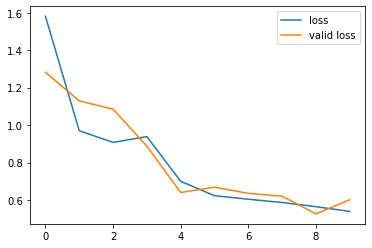

In [ ]:
# 学習ログをDataFrameに変換
history_df = pd.DataFrame(qnn_history.history) 
# 学習ログの保存
#history_df.to_csv("history_df.csv", index=None) 

# 損失のログの可視化
plt.plot(np.arange(len(history_df)), history_df['loss'], label='loss')
plt.plot(np.arange(len(history_df)), history_df['val_loss'], label='valid loss')
plt.legend()
plt.show()

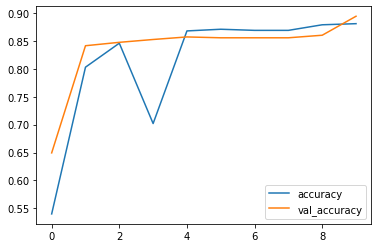

In [ ]:
# ACCの値のログの可視化
plt.plot(np.arange(len(history_df)), history_df['accuracy'], label='accuracy')
plt.plot(np.arange(len(history_df)), history_df['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()